In [31]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [32]:
import os
from pprint import pprint
from random import randint, choice
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [5]:
# Ensuring the GPU is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is being used')
else:
    print('GPU is not being used')

GPU is being used


In [6]:
# Path to dataset
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

# List all teh classes that are present in the dataset
classes = os.listdir(dataset_path)
num_of_classes = len(classes)

# print(num_of_classes)

print(f"Total number of classes: {num_of_classes}")
pprint(f"Classes: {classes}")
# pprint(classes)

Total number of classes: 90
("Classes: ['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', "
 "'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', "
 "'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', "
 "'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', "
 "'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', "
 "'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', "
 "'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', "
 "'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', "
 "'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', "
 "'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', "
 "'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', "
 "'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'jellyfish', 'ladybugs', "
 "'cockroach', 'hyena', 'cat', 'deer', 'turkey', 

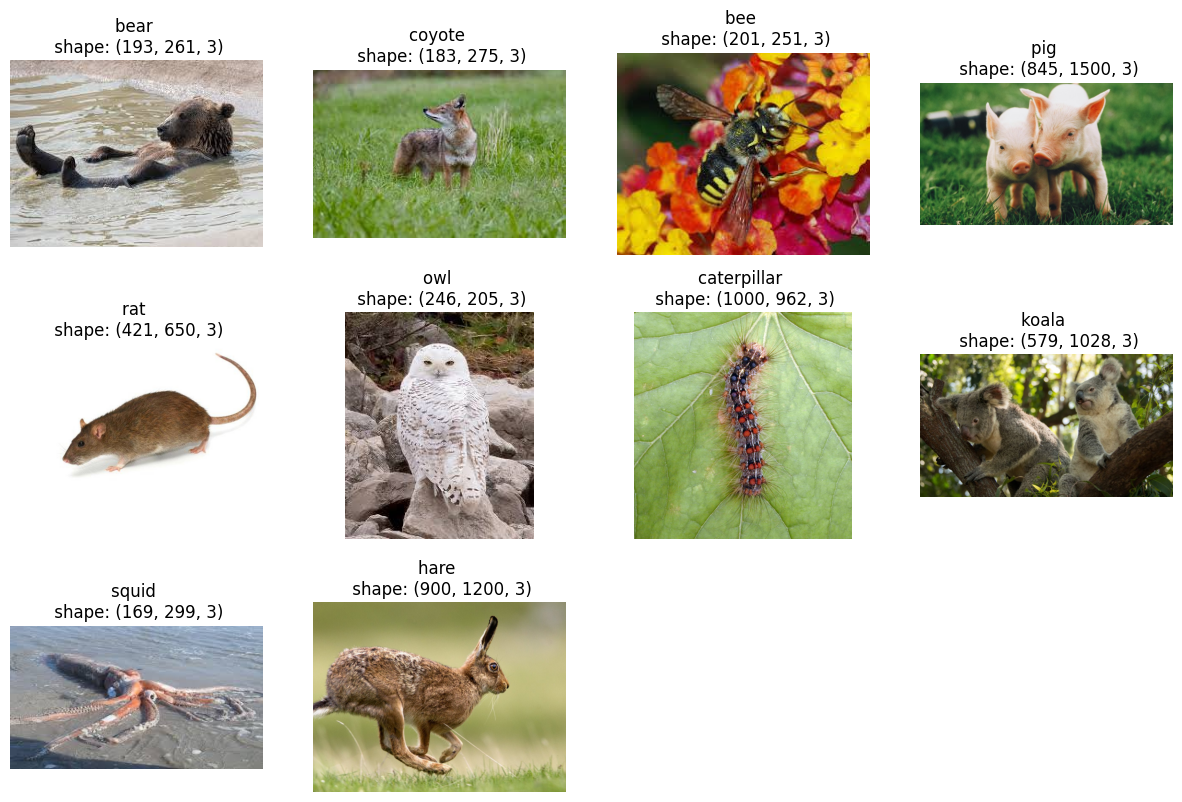

In [7]:
# Visualizing some sample images from the dataset
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes[30:40]):
  class_path = os.path.join(dataset_path, class_name)
  random_index = randint(0, len(os.listdir(class_path)) - 1)
  img_name = os.listdir(class_path)[random_index]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(3,4, i+1)
  plt.imshow(img)
  plt.title(f"{class_name} \n shape: {img.shape}")
  plt.axis('off')

plt.show()

In [8]:
# Preprocessing the data
# Defining the image size batch_size for the pre-trained model MobileNetV2
img_size = (224, 224)
batch_size = 64

# Preprocessing - Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255, # normalises the values [0,255] -> [0,1]
    validation_split=0.1, # takes 10 % of the total dataset for validation rest for training
)

# Training and Validation generators
train_generator = datagen.flow_from_directory(
  dataset_path,
  target_size=img_size,
  batch_size=batch_size,
  class_mode='categorical',
  subset='training'
)


validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [9]:
# Mapping the classses - class_indices
class_mapping = train_generator.class_indices
print(class_mapping)

# Extracing the class names from mapping
class_names = list(class_mapping.keys())
print(class_names)

{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

In [18]:
# Using the pre-trained model MobileNetV2 as the base model
base_model = MobileNetV2(
    weights = "imagenet",
    include_top = False,
    input_shape = (224, 224, 3)
)


# Freeze the base model weights, training
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_of_classes, activation='softmax')(x) # output layer

# Creating the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compiling the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summmary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = 20
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 562ms/step - accuracy: 0.3374 - loss: 3.1132 - val_accuracy: 0.7891 - val_loss: 0.8042
Epoch 2/20
 1/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.7812 - loss: 0.7221

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.7812 - loss: 0.7221 - val_accuracy: 0.8008 - val_loss: 0.8026
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 494ms/step - accuracy: 0.8289 - loss: 0.6104 - val_accuracy: 0.8027 - val_loss: 0.7040
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8594 - loss: 0.5091 - val_accuracy: 0.8105 - val_loss: 0.6840
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 537ms/step - accuracy: 0.8804 - loss: 0.4254 - val_accuracy: 0.8340 - val_loss: 0.6148
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9062 - loss: 0.4632 - val_accuracy: 0.8340 - val_loss: 0.5799
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.9307 - loss: 0.2329 - val_accuracy: 0.8457 - val_loss: 0.5730
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9062 - loss: 0.3387 - val_accuracy: 0.8516 - val_loss: 0.5515
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 560ms/step - accuracy: 0.9514 - loss: 0.1751 - val_accuracy: 0.8633 - val

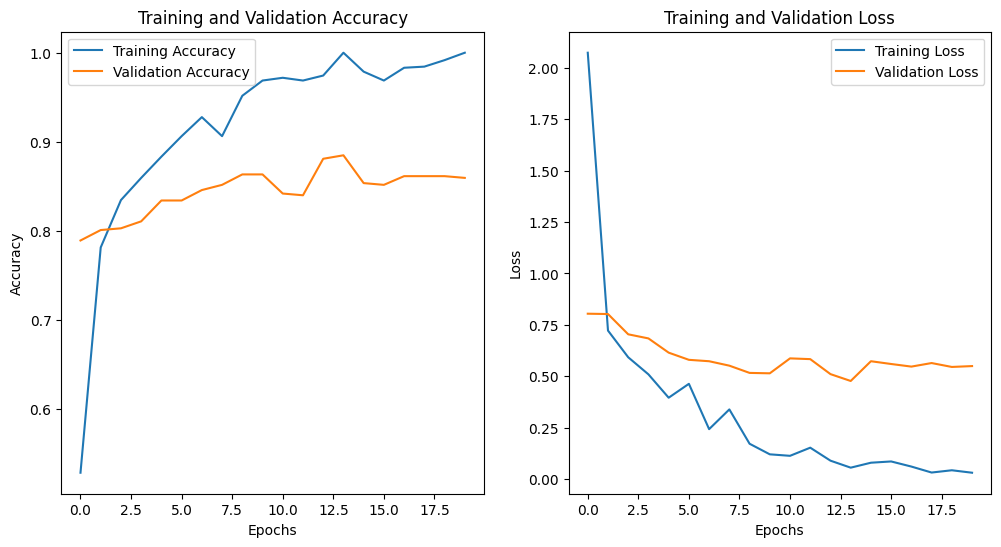

In [20]:
# Evaluating the model - plotting the training and valiation accuracy and loss
plt.figure(figsize=(12,6))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting LOss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 631ms/step - accuracy: 0.8554 - loss: 0.6336
Validation Loss: 0.5401061177253723
Validation Accuracy: 0.8611111044883728


In [22]:
# Save the model
model.save('edunet-final-model-MCAR.keras')

In [24]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('edunet-final-model-MCAR.keras')

def predict_animal(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

In [46]:
random_class = choice(os.listdir(dataset_path))
random_image = choice(os.listdir(os.path.join(dataset_path, random_class)))
# img_path = os.path.join(dataset_path, random_class, random_image)

print(random_class, random_image)

seahorse 23d44c6159.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


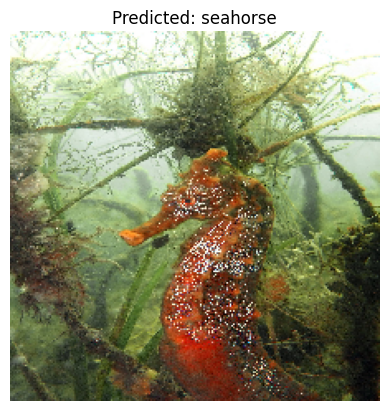

In [47]:
predict_animal(os.path.join(dataset_path, random_class, random_image))